In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math


# Data Preperation:

### Creating data

In [2]:

torch.manual_seed(42)   # keep the static starting point for generating random numbers

n_samples = 600
x1 = torch.randn(n_samples, 1) * 0.5 + torch.randint(0, 3, (n_samples,1)).float()
x2 = torch.randn(n_samples, 1) * 0.5 + torch.randint(0, 3, (n_samples,1)).float()

# Define target with some nonlinear relationship
y = ((x1**2 + x2) > 2.5).float()
y += 0.1*torch.randn_like(y)   # add label noise
y = (y > 0.5).float()
X = torch.cat([x1, x2], dim=1)



tensor([[-0.6484],
        [-0.7058],
        [ 0.6432],
        [ 1.4788],
        [ 1.1918]])

### Splitting data

In [3]:

# Split train / test
train_len = int(0.8 * len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test   = X[train_len:], y[train_len:]

print("Class balance:", y.mean().item())
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)


Class balance: 0.46666666865348816
X_train shape: torch.Size([480, 2]) y_train shape: torch.Size([480, 1])


# Model Preparation:

## Create Neural Network

In [ ]:
"""
weight matrix = numb(inp_features/or previous layer node count) x numb(current_neurons_count)
input matrix = numb(batchsize) x numb(inp_features)
"""

class neuralNetwork:

  def __init__(self, num_neurons, number_features):
    self.num_neurons = num_neurons
    self.bias= torch.ones(size=(1, self.num_neurons), dtype=torch.float32)
    self.weight = torch.randn((number_features, num_neurons)) * (1.0 / math.sqrt(number_features))

  def forward(self, input_data):
    self.X = input_data
    self.output = torch.matmul(self.X, self.weight) + self.bias
    return self.output

  def backward(self, dl_dw, dl_db, rate):
    self.weight -= rate * dl_dw
    self.bias -= rate * dl_db


### Activation:

In [ ]:
class ReLu_activation:

  def forward(self, node_z_value):
    return torch.maximum(torch.tensor(0.0), node_z_value)

  def backward(self, node_z_value):
    return (node_z_value>0).float()


class LeReLu_activation:   # LeakyRELu
    def forward(self, node_z_value):
        return torch.where(node_z_value > 0, node_z_value, 0.01*node_z_value)
    def backward(self, node_z_value):
        return torch.where(node_z_value > 0, torch.ones_like(node_z_value), torch.full_like(node_z_value, 0.01))


class Sigmoid_activation:

  def forward(self, node_z_value):
    return 1 / (1 + torch.exp(-node_z_value))


class SoftMax_activation:   #Last-layer(SoftMax):

  def forward(self, Lastlayer_output):
    exp_x = torch.exp(Lastlayer_output)
    softmax = exp_x/torch.sum(exp_x, dim=1, keepdim=True)   # dim--> summation along dim=1(along feature for each sample), keepdim--> increase dim by 1 which is deleted due to summation.

    return softmax



# Accuracy Metric:

In [ ]:
class Accuracy:

  def calculate(self, y_pred, y_actual):

    # # return torch.mean((y_actual==y_pred), dtype=torch.float64)
    # pred_classes = (y_pred > 0.5).float()
    # return (pred_classes == y_actual).float().mean()

    pred_classes = (y_pred > 0.5).float().view(-1)   # flatten to (batch,)
    y_actual = y_actual.view(-1).float()             # also flatten
    return (pred_classes == y_actual).float().mean()

# Loss function:

In [ ]:
class Loss_CrossEntropy:

  def forward(self, y_pred, y_actual):

    # Clip data to prevent division by log(0) =infinity error when y_pred=0, because for loss cal w'll be taking log of y_pred
    # Clip both sides to not drag mean towards any value
    y_pred_clipped = torch.clamp(y_pred, 1e-7, 1 - 1e-7)

    # Binary cross-entropy formula
    sample_loss = -(y_actual * torch.log(y_pred_clipped) +
                    (1 - y_actual) * torch.log(1 - y_pred_clipped))

    batchAvg_loss = torch.mean(sample_loss)

    return batchAvg_loss


  """Derivative of CrossEnropy Loss directly with respect to pre-activation (Z) for faster calculat no need to perform chain rule explicitly, already did on paper"""
  def backward(self, y_pred, y_actual):     # d_l/d_z => dl/d_sigm * d_sig/dz

    return y_pred - y_actual                # derivative of cross entropy function --> I derived on paper manually




# Training Loop

In [ ]:

batch_size=int(len(X_train)/12)

layer1 = neuralNetwork(num_neurons=3, number_features=2)
layer2 = neuralNetwork(num_neurons=2, number_features=3)
layer3 = neuralNetwork(num_neurons=1, number_features=2)
LeKrelu_activation = LeReLu_activation()
sigmoid_activation = Sigmoid_activation()
loss_crossEntropy = Loss_CrossEntropy()
accuracy = Accuracy()
# softmax_activation = SoftMax_activation()   #not to use in this network


# store logs
loss_history = []
accuracy_history = []
weights_history = []


#training loop
for epochs in range(5):     # In each epochs (for each batches(fwd->loss & bwd->update weight) )
  print("\n**** epoch - {0} ****\n".format(epochs))


  for start_idx in range(0, len(X_train), batch_size):    # looping next batch in the whole dataset
    end_idx = start_idx + batch_size          # creating slicing indexes

    # shiffling x_train in every epoch to not see repeatation of accuracy metric--better training
    perm = torch.randperm(len(X_train))
    X_train = X_train[perm]
    y_train = y_train[perm]

    """
    #############
    Forward prop --> (Z -> activation (for each layers till last layer) -> CrossEntropy loss (for last layer)
    #############
    """

    X_batch = X_train[start_idx:end_idx]        # X_train slicing into batch
    y_train_batch = y_train[start_idx:end_idx]  # y_train_batch slicing into batch


    layer1_output = layer1.forward(input_data=X_batch)
    layer1_relu_output = LeKrelu_activation.forward(node_z_value=layer1_output)

    layer2_output = layer2.forward(input_data=layer1_relu_output)
    layer2_relu_output = LeKrelu_activation.forward(node_z_value=layer2_output)


    # FINAL OUTPUT LAYER NEURON
    layer3_output = layer3.forward(input_data=layer2_relu_output)
    layer3_sigmoid_output = sigmoid_activation.forward(node_z_value=layer3_output)


    # LOSS
    loss = loss_crossEntropy.forward(y_pred=layer3_sigmoid_output, y_actual=y_train_batch)
    print("Loss: ", loss)

    # Accuracy Metrics
    accur = accuracy.calculate(y_pred=layer3_sigmoid_output, y_actual=y_train_batch)
    print("Accuracy: ", accur)


    """
    #############
    backward prop --> (loss -> activa -> Z -> input(prev_layer activation))
    #############
    d_l/d_w = (d_l/d_sigm) * (d_sigm/d_z) * (d_z/d_xw) * (d_xw/dw)
    d_l/d_b = (d_l/d_sigm) * (d_sigm/d_z) * (d_z/d_b)
    d_l/d_x = (d_l/d_sigm) * (d_sigm/d_z) * (d_z/d_xw) * (d_xw/dx)
    """

    ## Back-Calculation weight & bias for dw_3 and db_3:
    dl_dz_3 = loss_crossEntropy.backward(y_pred=layer3_sigmoid_output, y_actual=y_train_batch)
    dz3_dw_3 = layer2_relu_output                           # z3 = (w3 * relu_3) + b3
    # dz3_dw_3 = layer1_relu_output                         # z3 = (w3 * relu_3) + b3

    dl_dw_3 = torch.matmul(dz3_dw_3.T, dl_dz_3)             # (2, batch) x (batch, 1) = (2,1)

    dz_db_3 = 1
    dl_db_3 = dl_dz_3 * dz_db_3                             # (1,1)
    dl_db_3 = dl_db_3.sum(dim=0)                            # (1,2)

    ## Back-Calculation weight & bias for dw2 and db_2:

    dz3_drelu_2 = layer3.weight                                 # z3 = (w3 * relu_3) + b3
    dl_drelu_2 = torch.matmul(dl_dz_3, dz3_drelu_2.T)           # (batch,1) x (1,2) = (batch,2)
    drelu_dz_2 = LeKrelu_activation.backward(layer2_output)     # (batch,2)
    dl_dz_2 = dl_drelu_2 * drelu_dz_2                           # (batch,2)
    dz2_dw_2 = layer1_relu_output                               # (2,batch)

    dl_dw_2 = torch.matmul(dz2_dw_2.T, dl_dz_2)                 # (3, batch) x (batch, 2) = (3,2)

    dz_db_2 = 1
    dl_db_2 = dl_dz_2 * dz_db_2                                 # (1,2)
    dl_db_2 = dl_db_2.sum(dim=0)                                # (1,2)

    ## Back-Calculation weight & bias for dw1 and db_1:
    dz2_drelu_1 = layer2.weight
    dl_drelu_1 = torch.matmul(dl_dz_2, dz2_drelu_1.T)         # (batch,2)x(2,3)=(batch,3)
    drelu_dz_1 = LeKrelu_activation.backward(layer1_output)      # (batch,3)
    dl_dz1 = dl_drelu_1 * drelu_dz_1                          # (batch,3)
    dz1_dw_1 = X_batch                                        # (batch,2)

    dl_dw_1 = torch.matmul(dz1_dw_1.T, dl_dz1)                # (2,batch)x(batch,3) = (2,3)

    dz_db_1 = 1
    dl_db_1 = dl_dz1 * dz_db_1                                # (1,3)
    dl_db_1 = dl_db_1.sum(dim=0)                              # (1,3)
    # print("dl_db_1:",dl_db_1.shape)


    ## Update weights (in each layers)
    layer1.backward(dl_dw=dl_dw_1, dl_db=dl_db_1, rate= 0.2)
    layer2.backward(dl_dw=dl_dw_2, dl_db=dl_db_2, rate= 0.3)
    layer3.backward(dl_dw=dl_dw_3, dl_db=dl_db_3, rate= 0.001)

    loss_history.append(loss.item())
    accuracy_history.append(accur.item())

    # # flatten weights of one layer (say layer2) to track

    weights_history.append(layer1.weight.detach().clone().numpy())



**** epoch - 0 ****

Loss:  tensor(0.9993)
Accuracy:  tensor(0.4750)
Loss:  tensor(0.7794)
Accuracy:  tensor(0.4750)
Loss:  tensor(0.8763)
Accuracy:  tensor(0.3500)
Loss:  tensor(0.8115)
Accuracy:  tensor(0.4250)
Loss:  tensor(0.7556)
Accuracy:  tensor(0.5000)
Loss:  tensor(0.7785)
Accuracy:  tensor(0.4500)
Loss:  tensor(0.7233)
Accuracy:  tensor(0.5500)
Loss:  tensor(0.7627)
Accuracy:  tensor(0.4750)
Loss:  tensor(0.6941)
Accuracy:  tensor(0.5750)
Loss:  tensor(0.7393)
Accuracy:  tensor(0.5000)
Loss:  tensor(0.7161)
Accuracy:  tensor(0.5000)
Loss:  tensor(0.7179)
Accuracy:  tensor(0.5000)

**** epoch - 1 ****

Loss:  tensor(0.7751)
Accuracy:  tensor(0.4250)
Loss:  tensor(0.7796)
Accuracy:  tensor(0.4000)
Loss:  tensor(0.7393)
Accuracy:  tensor(0.4250)
Loss:  tensor(0.7945)
Accuracy:  tensor(0.3250)
Loss:  tensor(0.7789)
Accuracy:  tensor(0.3500)
Loss:  tensor(0.7022)
Accuracy:  tensor(0.5000)
Loss:  tensor(0.7062)
Accuracy:  tensor(0.4750)
Loss:  tensor(0.7781)
Accuracy:  tensor(0.35

# Plotting Weight update graph of layer-1:
 --> Just to check whether network stop learning or not

weights_history shape: (60, 2, 3)


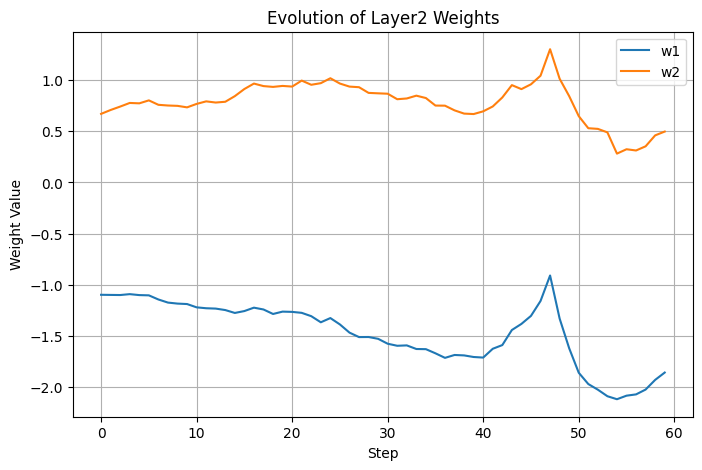

In [ ]:
# weight history into numpy array
weights_history = np.array(weights_history)  # shape = (epochs, in_features, out_features)
print("weights_history shape:", weights_history.shape)


fig = plt.figure(figsize=(8,5))

for i in range(weights_history.shape[1]):   # iterate over all weights
    plt.plot(range(weights_history.shape[0]), weights_history[:,i,0], label=f'w{i+1}')

plt.xlabel("Step")
plt.ylabel("Weight Value")
plt.title("Evolution of Layer2 Weights")
plt.legend()
plt.grid(True)
plt.show()



# Animating Loss and accuracy:
--> For all samples in the batch in each epochs.

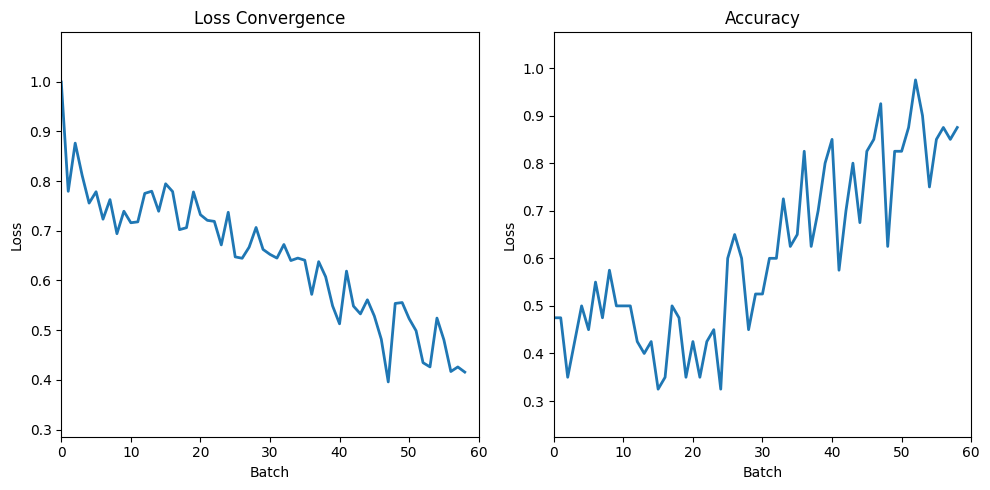

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# --------- ANIMATION ---------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# init plots
loss_line, = ax1.plot([], [], lw=2, label="Loss")
ax1.set_xlim(0, len(loss_history))
ax1.set_ylim(min(loss_history)-0.1, max(loss_history)+0.1)
ax1.set_title("Loss Convergence")
ax1.set_xlabel("Batch")
ax1.set_ylabel("Loss")

# init plots
accuracy_line, = ax2.plot([], [], lw=2, label="Accuracy")
ax2.set_xlim(0, len(accuracy_history))
ax2.set_ylim(min(accuracy_history)-0.1, max(accuracy_history)+0.1)
ax2.set_title("Accuracy")
ax2.set_xlabel("Batch")
ax2.set_ylabel("Loss")


def init():
    loss_line.set_data([], [])
    accuracy_line.set_data([], [])

    return loss_line, accuracy_line


def update(frame):
    # loss curve
    loss_line.set_data(range(frame), loss_history[:frame])

    # accuracy curve
    accuracy_line.set_data(range(frame), accuracy_history[:frame])

    return loss_line, accuracy_line


ani = animation.FuncAnimation(fig, update, frames=len(loss_history),
                              init_func=init, blit=True, interval=100)

plt.tight_layout()
HTML(ani.to_jshtml())

